In [1]:
# https://theailearner.com/2019/12/05/finding-convex-hull-opencv-python/
# https://stackoverflow.com/questions/19400376/how-to-draw-circles-with-random-colors-in-opencv/19401384
# https://stackoverflow.com/questions/18563680/sorting-2d-list-python/18564382
# https://stackoverflow.com/questions/62629743/removing-blank-space-around-a-circle-shaped-mask
# https://answers.opencv.org/question/51375/help-detectingtracking-circles-with-findcontours/

In [2]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [3]:
dataset_path = "./BinRushed2/"
fnames = [f'{f[:-4]}' for f in sorted(os.listdir(f'{dataset_path}')) if "image" in f]
unique_images = []
for i in range(1, len(fnames)//7 + 1):
    unique_images.append(f"image{i}-1")

In [4]:
len(unique_images)

47

46


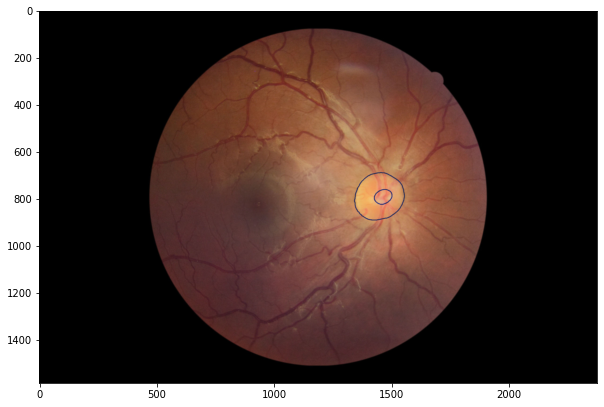

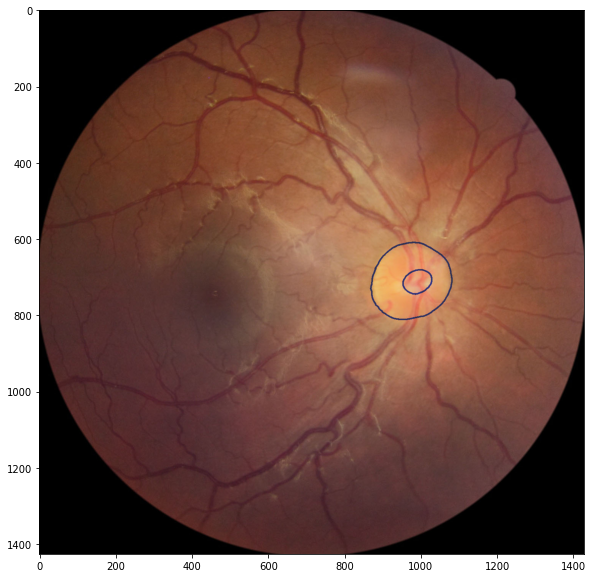

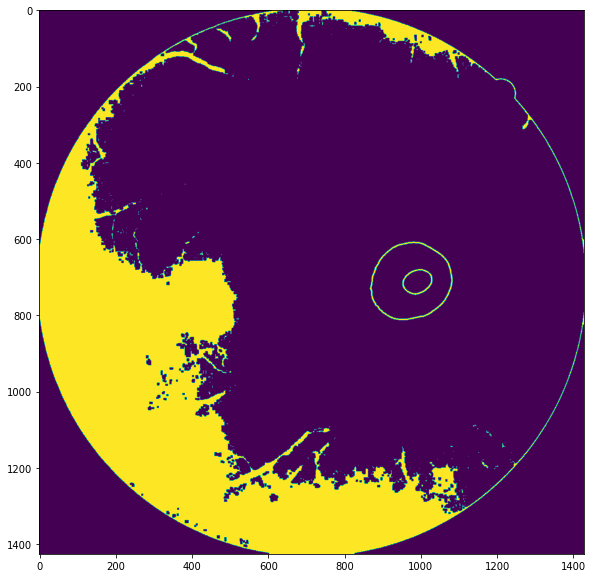

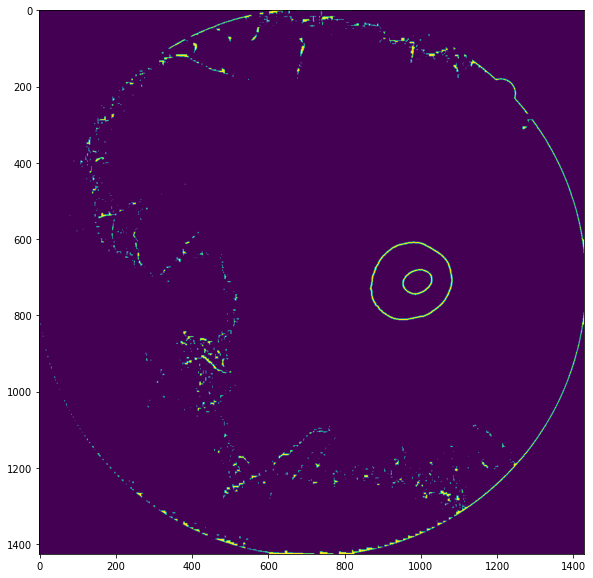

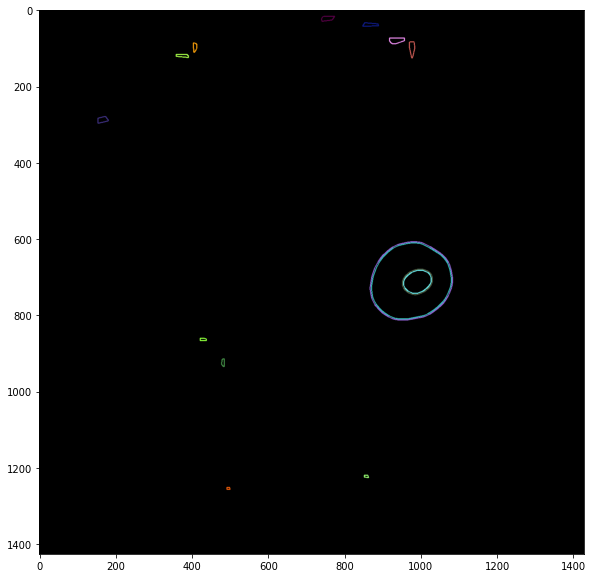

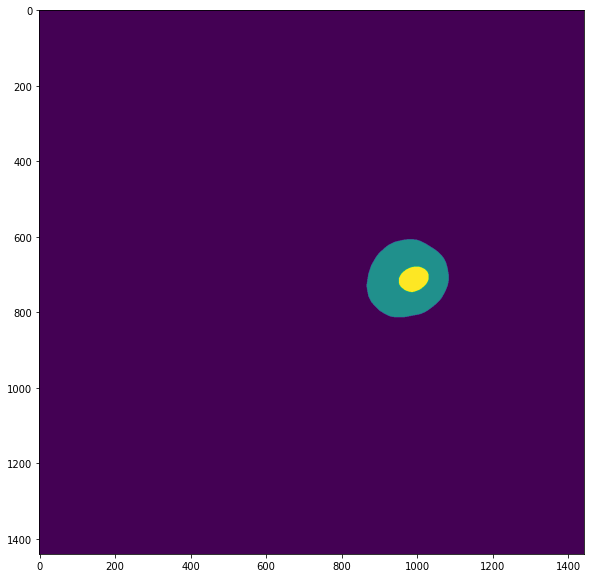

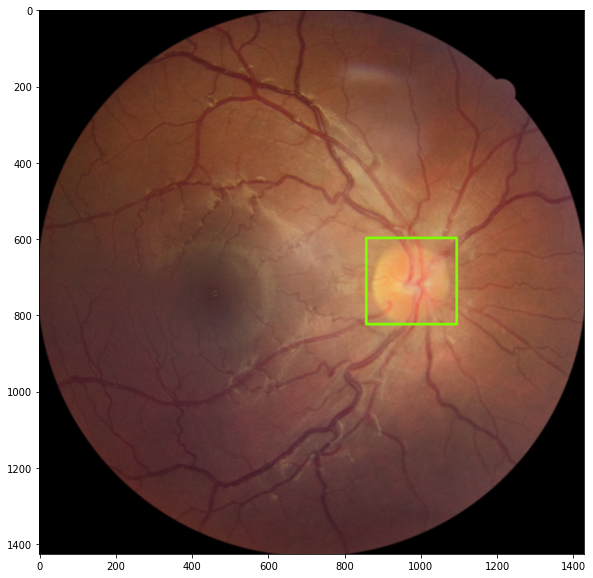

In [8]:
for idx in range(46, len(unique_images)):
# idx +=1
    print(idx)
    raw_image = cv2.imread(f'{dataset_path}{unique_images[idx]}.jpg')
    rgb_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10,10))
    plt.imshow(rgb_image)
    plt.show()
    img_gray = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)

    # plt.imshow(img_gray)
    # plt.show()

    im = img_gray > 20
    # plt.figure(figsize=(10,10))
    # plt.imshow(im)
    # plt.show()

    (r, c) = np.where(im == 1)
    min_row, min_col = np.min(r), np.min(c)
    max_row, max_col = np.max(r), np.max(c)
    padding = 5
    image_crop = rgb_image[min_row+padding:max_row-padding, min_col+padding:max_col-padding]
    plt.figure(figsize=(10,10))
    plt.imshow(image_crop)
    plt.show()
#     threshold_l = np.array([20, 35, 25])
#     threshold_h = np.array([70, 60, 150])
    input_image = image_crop.copy()
    threshold_l = np.array([5, 20, 10])
    threshold_h = np.array([90, 80, 170])
    mask = cv2.inRange(input_image, threshold_l, threshold_h )
    output = cv2.bitwise_and(input_image,input_image, mask= mask)
    gray = cv2.cvtColor(output, cv2.COLOR_BGR2GRAY)
    # plt.figure(figsize=(10,10))
    # plt.imshow(gray)
    # plt.show()

    kernel = np.ones((5,5), np.uint8)
    closing = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)
    # plt.figure(figsize=(10,10))
    # plt.imshow(closing)
    # plt.show()

    kernel = np.ones((1,1), np.uint8)
    dilation = cv2.dilate(closing, kernel, iterations=1)
    # plt.figure(figsize=(10,10))
    # plt.imshow(dilation)
    # plt.show()

    _, thresh = cv2.threshold(dilation, 0, 10,cv2.THRESH_BINARY)
    plt.figure(figsize=(10,10))
    plt.imshow(thresh)
    plt.show()

    height,width = thresh.shape
    kernel_size = 15
    pad = (kernel_size - 1) // 2
    image = cv2.copyMakeBorder(thresh, pad, pad, pad, pad, cv2.BORDER_CONSTANT, None, value = 0)
    for y in np.arange(kernel_size, height + kernel_size):
        for x in np.arange(kernel_size, width + kernel_size):
            roi = image[y - pad:y + pad + 1, x - pad:x + pad + 1]
            nonzero = np.count_nonzero(roi)
            if  nonzero >= kernel_size*kernel_size//2:
                 image[y - pad:y + pad + 1, x - pad:x + pad + 1] = 0
    height,width = image.shape
    image = image[pad:height-pad, pad:width-pad]   
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    plt.show()


    contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    shapes = []

    # out_image = image_rgb.copy()
    out_image = np.zeros(input_image.shape, dtype=np.uint8)
    for i in range(len(contours)):
        hull = cv2.convexHull(contours[i])
        area = cv2.contourArea(hull)
        x,y,w,h = cv2.boundingRect(hull)
    #     r = min(w,h)/2
        ideal_area = np.pi*(w/2)*(h/2)



        if area/ideal_area >= 0.8:
            shapes.append([hull, area])

    for hull, _ in shapes:
        color_ = (list(np.random.choice(range(256), size=3)))  
        color =[int(color_[0]), int(color_[1]), int(color_[2])] 
        cv2.drawContours(out_image, [hull], -1, color, 2)
    plt.figure(figsize=(10,10))
    plt.imshow(out_image)
    plt.show()

    shapes = sorted(shapes,key=lambda l:l[1], reverse=True)
    final_mask = [shapes[0][0]]
    for hull, area in shapes:
#         print(area/shapes[0][1])
        if 0.025 <= area/shapes[0][1] <= 0.75:
            final_mask.append(hull)
            break


#     out_image = input_image.copy()
#     cv2.drawContours(out_image,[final_mask[0]], -1, (0,0,255), 2)
#     cv2.drawContours(out_image,[final_mask[1]], -1, (0,255,0), 2)
#     plt.figure(figsize=(10,10))
#     plt.imshow(out_image)
#     plt.show()

#     mask_image = np.zeros(input_image.shape, dtype=np.uint8)
#     cv2.fillPoly(mask_image,[final_mask[0]], (0,0,255))
#     cv2.fillPoly(mask_image,[final_mask[1]], (0,255,0))
#     # cv2.imwrite('test.jpg', mask_image)
#     plt.figure(figsize=(10,10))
#     plt.imshow(mask_image)
#     plt.show()
    
    blank_image = np.zeros((height,width,1), dtype = np.uint8)
    cv2.fillPoly(blank_image,[final_mask[0]], 1)
    cv2.fillPoly(blank_image,[final_mask[1]], 2)
    plt.figure(figsize=(10,10))
    plt.imshow(blank_image)
    plt.show()
    
    x,y,w,h = cv2.boundingRect(final_mask[0])
    color = (128, 255, 0)
    thickness = 6
    prime_image = cv2.imread(f'{dataset_path}{unique_images[idx].split("-")[0]}prime.jpg')
#     prime_image = image[min_row+padding:max_row-padding, min_col+padding:max_col-padding]
    prime_image = cv2.cvtColor(prime_image[min_row+padding:max_row-padding, min_col+padding:max_col-padding],
                               cv2.COLOR_BGR2RGB)

    image = cv2.rectangle(prime_image, (x-10,y-10),(x+w+10,y+h+10), color, thickness)
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    plt.show()

In [6]:
# [min_row+padding:max_row-padding, min_col+padding:max_col-padding]